In [1]:
# Import the necessary libraries
import pandas as pd
import keras_tuner as kt
from tensorflow.keras.layers import Dense, Dropout, InputLayer
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import (
    EarlyStopping, 
    ReduceLROnPlateau, 
    ModelCheckpoint, 
    TensorBoard,
    CSVLogger
)
import os
from datetime import datetime
import numpy as np
from sklearn.model_selection import KFold
# Import the necessary libraries



# Define the file paths
subdirectory = "pickle_data_Brot"
training_features_path = f"{subdirectory}/training_features.pkl"
validation_features_path = f"{subdirectory}/validation_features.pkl"
test_features_path = f"{subdirectory}/test_features.pkl"
training_labels_path = f"{subdirectory}/training_labels.pkl"
validation_labels_path = f"{subdirectory}/validation_labels.pkl"
test_labels_path = f"{subdirectory}/test_labels.pkl"

# Read the pickle files
training_features = pd.read_pickle(training_features_path)
validation_features = pd.read_pickle(validation_features_path)
test_features = pd.read_pickle(test_features_path)
training_labels = pd.read_pickle(training_labels_path)
validation_labels = pd.read_pickle(validation_labels_path)
#test_labels = pd.read_pickle(test_labels_path)

# Verify the loaded data by printing their shapes and a few rows
print("Loaded Training features dimensions:", training_features.shape)
print("Loaded Validation features dimensions:", validation_features.shape)
print("Loaded Test features dimensions:", test_features.shape)
print()
print("Loaded Training labels dimensions:", training_labels.shape)
print("Loaded Validation labels dimensions:", validation_labels.shape)
#print("Loaded Test labels dimensions:", test_labels.shape)
print()

print("First few rows of loaded training features:")
print(training_features.head())
print()
print("First few rows of loaded training labels:")
print(training_labels.head())


2025-01-07 20:42:45.325346: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-07 20:42:45.352648: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736278965.378503 1912338 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736278965.386146 1912338 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-07 20:42:45.433905: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

Loaded Training features dimensions: (1462, 30)
Loaded Validation features dimensions: (357, 30)
Loaded Test features dimensions: (355, 30)

Loaded Training labels dimensions: (1462, 1)
Loaded Validation labels dimensions: (357, 1)

First few rows of loaded training features:
   Temp_Very_Cold_current  Temp_Cold_current  Temp_Mild_current  \
0                       0                  0                  1   
1                       0                  0                  1   
2                       0                  0                  0   
3                       0                  0                  1   
4                       0                  0                  1   

   Temp_Warm_current  Temp_Hot_current  Cloud_ok_current  \
0                  0                 0                 0   
1                  0                 0                 1   
2                  1                 0                 0   
3                  0                 0                 0   
4                  0

In [2]:
class BayesianNeuralTuner:
    def __init__(
        self,
        input_shape,
        max_trials=10,
        project_name='nn_tuning',
        log_dir='logs',
        n_folds=3
    ):
        self.input_shape = input_shape
        self.max_trials = max_trials
        self.project_name = project_name
        self.log_dir = os.path.join(log_dir, datetime.now().strftime("%Y%m%d-%H%M%S"))
        self.n_folds = n_folds
        os.makedirs(self.log_dir, exist_ok=True)
        
    def build_model(self, hp):
        # Use factors of 2 for more efficient GPU utilization
        units1_choices = [32, 64, 96, 128]
        units2_choices = [16, 32, 48, 64]
        
        model = Sequential([
            InputLayer(shape=self.input_shape),
            
            # First dropout with tunable rate
            Dropout(hp.Float('dropout1', 0.1, 0.3, step=0.1)),
            
            # First dense layer with conditional units
            Dense(
                units=hp.Choice('units1', units1_choices),
                activation=hp.Choice('activation1', ['relu', 'selu']),
                kernel_regularizer=l2(hp.Float(
                    'l2_reg1', 
                    1e-4, 
                    1e-2, 
                    sampling='log'
                )),
                kernel_initializer='he_normal'
            ),
            
            # Second dense layer with conditional units
            Dense(
                units=hp.Choice('units2', units2_choices),
                activation=hp.Choice('activation2', ['relu', 'selu']),
                kernel_regularizer=l2(hp.Float(
                    'l2_reg2', 
                    1e-4, 
                    1e-2, 
                    sampling='log'
                )),
                kernel_initializer='he_normal'
            ),
            
            Dense(1)
        ])
        
        # Learning rate with warm restarts
        base_lr = hp.Float(
            'base_learning_rate',
            min_value=1e-4,
            max_value=1e-2,
            sampling='log'
        )
        
        # Optimizer with tunable parameters
        optimizer = AdamW(
            learning_rate=base_lr,
            beta_1=hp.Float('beta_1', 0.9, 0.999),
            beta_2=hp.Float('beta_2', 0.9, 0.999),
            weight_decay=hp.Float('weight_decay', 1e-4, 1e-2, sampling='log')
        )
        
        model.compile(
            optimizer=optimizer,
            loss='mse',
            metrics=['mape']
        )
        
        return model
    
    def get_callbacks(self, checkpoint_path, fold=None):
        fold_suffix = f'_fold_{fold}' if fold is not None else ''
        return [
            EarlyStopping(
                monitor='val_loss',
                patience=5,
                restore_best_weights=True,
                verbose=1
            ),
            ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.5,
                patience=3,
                min_lr=1e-6,
                verbose=1
            ),
            ModelCheckpoint(
                filepath=checkpoint_path.format(fold=fold_suffix),
                monitor='val_loss',
                save_best_only=True,
                verbose=1
            ),
            TensorBoard(
                log_dir=os.path.join(self.log_dir, f'fold{fold_suffix}'),
                histogram_freq=1,
                write_graph=True
            ),
            CSVLogger(
                os.path.join(self.log_dir, f'training_log{fold_suffix}.csv'),
                separator=',',
                append=False
            )
        ]
    
    def cross_validate_hyperparameters(self, hp, x, y, batch_size):
        """Perform k-fold cross-validation for a set of hyperparameters"""
        kf = KFold(n_splits=self.n_folds, shuffle=True, random_state=42)
        scores = []
        
        for fold, (train_idx, val_idx) in enumerate(kf.split(x)):
            x_train_fold = x[train_idx]
            y_train_fold = y[train_idx]
            x_val_fold = x[val_idx]
            y_val_fold = y[val_idx]
            
            model = self.build_model(hp)
            checkpoint_path = os.path.join(self.log_dir, 'model_cv_{fold}.h5')
            callbacks = self.get_callbacks(checkpoint_path, fold)
            
            model.fit(
                x_train_fold,
                y_train_fold,
                epochs=100,
                batch_size=batch_size,
                validation_data=(x_val_fold, y_val_fold),
                callbacks=callbacks,
                verbose=0
            )
            
            scores.append(model.evaluate(x_val_fold, y_val_fold)[0])
        
        return np.mean(scores)
    
    def search(self, training_features, training_labels, validation_data, batch_size=24):
        checkpoint_path = os.path.join(self.log_dir, 'best_model.keras')
        
        # Initialize Bayesian Optimization tuner
        tuner = kt.BayesianOptimization(
            self.build_model,
            objective=kt.Objective('val_loss', direction='min'),
            max_trials=self.max_trials,
            directory=self.log_dir,
            project_name=self.project_name,
            overwrite=True
        )
        
        # Print search space summary
        tuner.search_space_summary()
        
        # Implement early stopping for the hyperparameter search
        stop_early = EarlyStopping(
            monitor='val_loss',
            min_delta=1e-4,
            patience=3
        )
        
        # Search with cross-validation
        tuner.search(
            training_features,
            training_labels,
            epochs=100,
            batch_size=batch_size,
            validation_data=validation_data,
            callbacks=self.get_callbacks(checkpoint_path),
            verbose=1
        )
        
        # Get best hyperparameters
        best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
        
        # Print detailed results
        print("\nBest Hyperparameters:")
        for param, value in best_hps.values.items():
            print(f"{param}: {value}")
        
        # Build and train final model with best parameters
        best_model = tuner.hypermodel.build(best_hps)
        
        history = best_model.fit(
            training_features,
            training_labels,
            epochs=100,
            batch_size=batch_size,
            validation_data=validation_data,
            callbacks=self.get_callbacks(checkpoint_path),
            verbose=1
        )
        
        return best_model, history, best_hps


In [10]:

tuner = BayesianNeuralTuner(
    input_shape=(training_features.shape[1],),
    max_trials=10,
    n_folds=3
)

best_model, history, best_hps = tuner.search(
    training_features,
    training_labels,
    validation_data=(validation_features, validation_labels)
)

Trial 10 Complete [00h 00m 57s]
val_loss: 1213.5301513671875

Best val_loss So Far: 938.81689453125
Total elapsed time: 00h 05m 33s

Best Hyperparameters:
dropout1: 0.2
units1: 32
activation1: relu
l2_reg1: 0.009925530546395422
units2: 64
activation2: relu
l2_reg2: 0.00458502351256499
base_learning_rate: 0.00033587186424780983
beta_1: 0.9719311428881368
beta_2: 0.9153644416804168
weight_decay: 0.006404687722635315
Epoch 1/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 15734.9111 - mape: 99.2074
Epoch 1: val_loss improved from inf to 17018.51562, saving model to logs/20250107-222014/best_model.keras
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - loss: 15739.0518 - mape: 99.2016 - val_loss: 17018.5156 - val_mape: 98.2245 - learning_rate: 3.3587e-04
Epoch 2/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 15862.6426 - mape: 97.7052
Epoch 2: val_loss improved from 17018.51562 to 16549.32422, saving model to logs/20250107-222014/best_model.keras
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - l

In [13]:
early_stopping = EarlyStopping(
    monitor='val_loss',  # Überwachung der Validierungsverlust
    patience=20,         # Anzahl der Epochen ohne Verbesserung
    restore_best_weights=True  # Stellt das Modell mit den besten Gewichten wieder her
)
# Train the final model
history = best_model.fit(
    training_features,
    training_labels,
    epochs=100,
    batch_size=24,
    validation_data=(validation_features, validation_labels),
    callbacks=[early_stopping]
)

Epoch 1/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1024.1887 - mape: 22.1366 - val_loss: 944.6790 - val_mape: 18.1607
Epoch 2/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 975.8282 - mape: 20.8871 - val_loss: 951.7713 - val_mape: 18.0891
Epoch 3/100
61/61 ━━━━━━━━━━━━━━━━━━━━ -1s -24737us/step - loss: 875.2463 - mape: 20.3188 - val_loss: 940.5849 - val_mape: 18.1560
Epoch 4/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 937.6800 - mape: 20.9784 - val_loss: 939.3431 - val_mape: 18.1589
Epoch 5/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 1017.3293 - mape: 22.2650 - val_loss: 943.2618 - val_mape: 18.1223
Epoch 6/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 1049.7053 - mape: 21.2339 - val_loss: 943.9595 - val_mape: 18.1195
Epoch 7/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 880.2420 - mape: 20.7368 - val_loss: 948.5884 - val_mape: 18.0663
Epoch 8/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 920.7029 - mape: 20.4419 - val_loss: 949.1620 - va

In [15]:
# Saving the trained Model
best_model.save("python_model_Brot.h5")

In [16]:
# Making Predictions and Evaluating the Model
import numpy as np

def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_mask = y_true != 0
    return np.mean(np.abs((y_true[non_zero_mask] - y_pred[non_zero_mask]) / y_true[non_zero_mask])) * 100

training_predictions = best_model.predict(training_features)
validation_predictions = best_model.predict(validation_features)
print(f"MAPE on the Training Data: {mape(training_labels, training_predictions):.2f}%")
print(f"MAPE on the Validation Data: {mape(validation_labels, validation_predictions):.2f}%")

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
MAPE on the Training Data: 18.51%
MAPE on the Validation Data: 18.09%


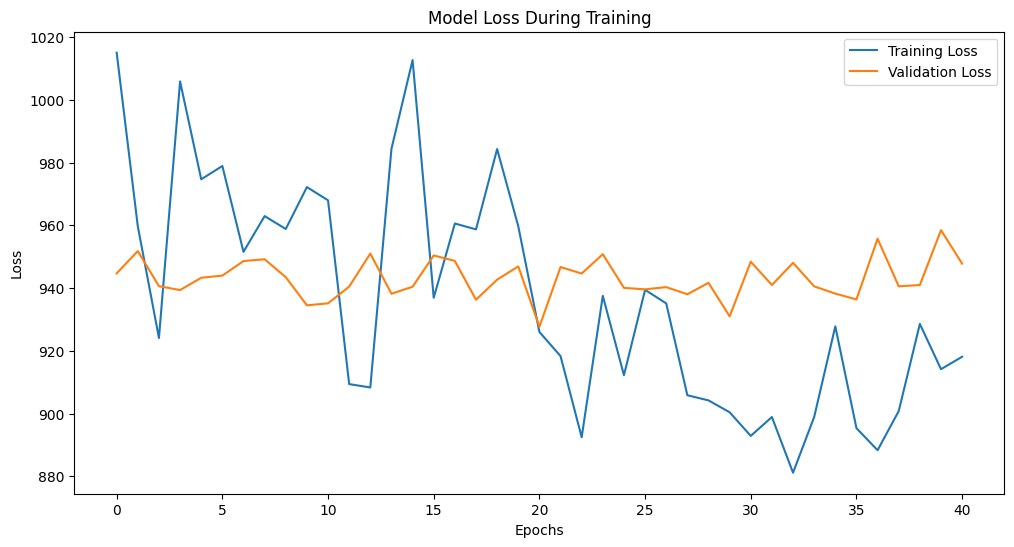

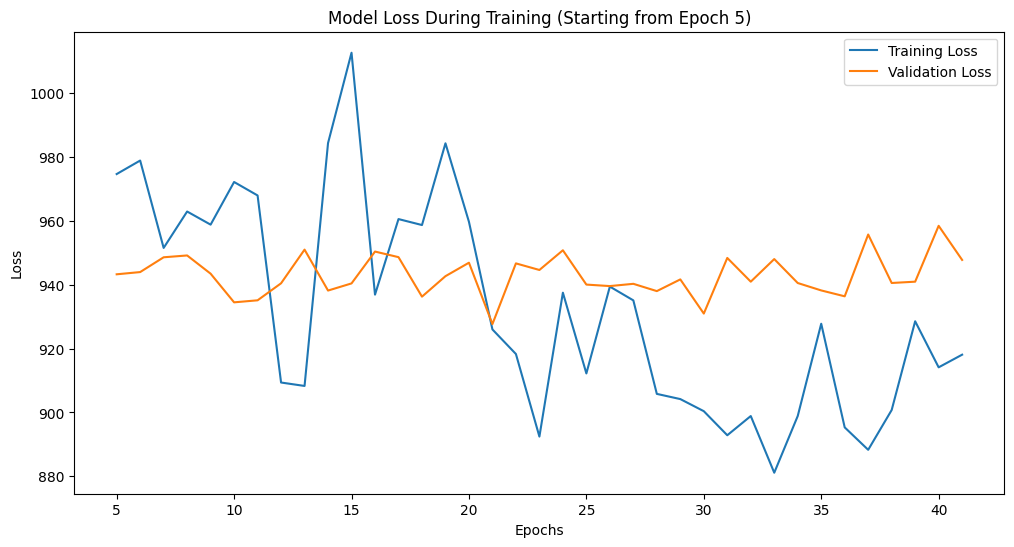

In [17]:
# Plotting Training History
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting Training History (ab der 5. Epoche)
import matplotlib.pyplot as plt

# Schneide die Verlaufsdaten ab der 5. Epoche
epochs_to_plot = range(5, len(history.history['loss']) + 1)
training_loss = history.history['loss'][4:]
validation_loss = history.history['val_loss'][4:]

plt.figure(figsize=(12, 6))
plt.plot(epochs_to_plot, training_loss, label='Training Loss')
plt.plot(epochs_to_plot, validation_loss, label='Validation Loss')
plt.title('Model Loss During Training (Starting from Epoch 5)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


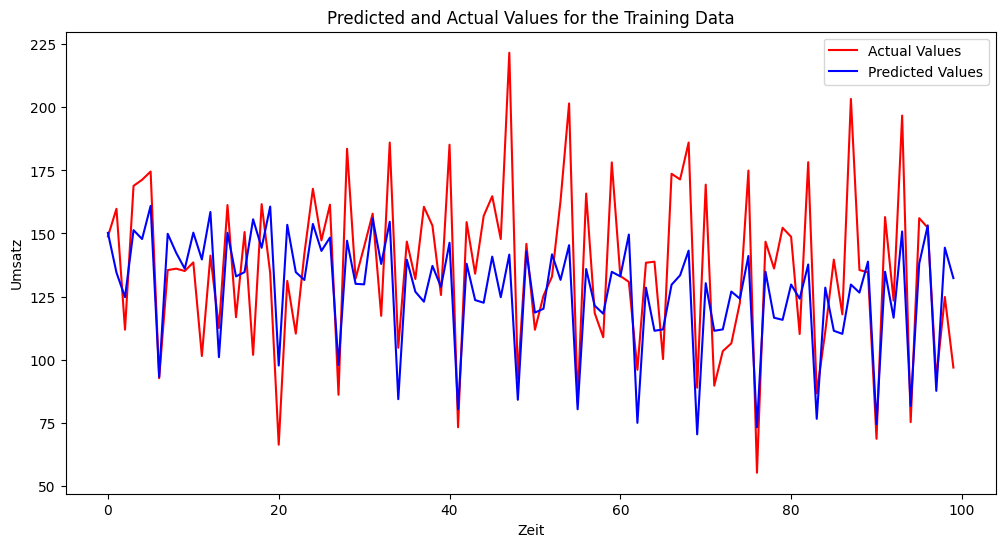

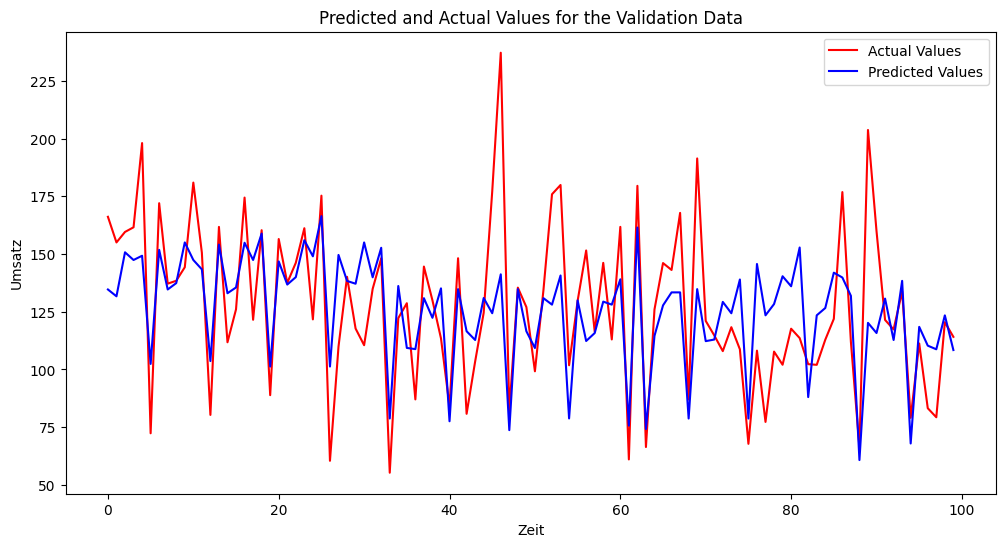

In [18]:
def plot_predictions(data, title):
    plt.figure(figsize=(12, 6))
    plt.plot(data['actual'], label='Actual Values', color='red')
    plt.plot(data['prediction'], label='Predicted Values', color='blue')
    plt.title(title)
    plt.xlabel('Zeit')
    plt.ylabel('Umsatz')
    plt.legend()
    plt.show()

# Ensure that training_predictions, validation_predictions, training_labels, and validation_labels are numpy arrays
training_predictions = np.array(training_predictions).flatten()
validation_predictions = np.array(validation_predictions).flatten()
training_labels = np.array(training_labels).flatten()
validation_labels = np.array(validation_labels).flatten()

# print the type of the predictions
print(type(training_predictions))
print(type(validation_predictions))

# Create DataFrames with 1-dimensional arrays
data_train = pd.DataFrame({'prediction': training_predictions, 'actual': training_labels})
data_validation = pd.DataFrame({'prediction': validation_predictions, 'actual': validation_labels})

# Plot predictions
plot_predictions(data_train.head(100), 'Predicted and Actual Values for the Training Data')
plot_predictions(data_validation.head(100), 'Predicted and Actual Values for the Validation Data')

***VORHERSAGE TESTZEITRAUM***

In [ ]:
test_predictions = model.predict(test_features)
#print("Predictions for test data:", test_predictions[:5])  # Display first 5 predictions
# Größe des Arrays anzeigen
print("Größe des Arrays (shape):", test_predictions.shape)
test_predictions = pd.DataFrame(test_predictions)
test_predictions

In [ ]:
data_test = pd.read_csv("/workspaces/bakery_sales_prediction/0_DataPreparation/00_data/data_with_lag/Testdaten_with_lag.csv")
data_test = data_test[data_test["Warengruppe_1"] == 1]
data_test

In [ ]:
# Erstelle Ziel csv Datei

predictions_df = pd.DataFrame({
    'id': data_test['id'].values,
    'Umsatz': test_predictions[0].values
}).reset_index(drop=True)

# Save to a CSV file
#output_csv_path = "/workspaces/bakery_sales_prediction/3_Model/02_Franz/V3_lag/Umsatzvorhersage_Broetchen_Hochladeformat.csv"

predictions_df.to_csv('Brot_Umsatzvorhersage.csv', index=False)
print(f"CSV Datei erstellt")